# Simulating multivariate effects based on temporal kernel

In the previous example, we showed how to use the toolbox to specify multivariate effects of contrasts between experimental conditions at precise timepoints. You may have noticed that the generated effects look a bit too abrupt temporally to be realistic. That is because, by default, the toolbox generates multivariate effects with the same amplitude at all time points you specified to be on. In real data however, this is not the case. Typically, you would expect decoding to rise not at once but over some time. Similarly, you would not expect the effect to vanish suddenly, but rather to vanish over a period of time. 

To simulate more realistic temporal dynamics of multivariate effects, you can specify a temporal kernel that will be convolved with the effects you have specified. In this tutorial, we will illustrate how to do so.

## 1. Setting up the simulation

Just as in the simulation before, we need to specify a design matrix, the time windows for our effects, as well as the characteristics of our effects (number of channels, number of participants, number of samples per trials...). We will take the same parameters as before. 

In [ ]:
import numpy as np
from scipy.stats import gamma as gamma_dist
import matplotlib.pyplot as plt

# Creating the design matrix of our 2 by two balanced design:
X = np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T

# Add descriptors:
cond_names = ["category", "attention"]
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"},
}

# The 'effects' array tells us which columns in X are 'active' at each time window.
# Here we say effect 0 => category, effect 1 => attention
effects = np.array([0, 1])

# For each effects, define a 2x2 array where each row is [start_ms, end_ms]
t_win = np.array(
    [
        [0.100, 0.200],  # Condition 0 active window
        [0.300, 0.400],  # Condition 1 active window
    ]
)

# Effect size:
effect_size = [0.5, 0.5]

# Data parameters:
n_channels = 64  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 2  # Variance of the data
ch_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz
tmin = -0.25
tmax = 1.0

## 2. Specifying the temporal kernel
To specify mutlivariate effects with more realistic temporal dynamics, we need to define a temporal kernel. This kernel will then be convolved with the time window we have specified for each effect, such that the mutlivariate effects follow these temporal dynamics. To illustrate it, we will use a gamma kernel. A gamma function looks like a Gaussian, except it is skewed towards the right, such that the right tail is longer. This captures nicely the typical dynamics of multivariate effect and of ERPs, where we typically see a quick rise followed by a slower decay:

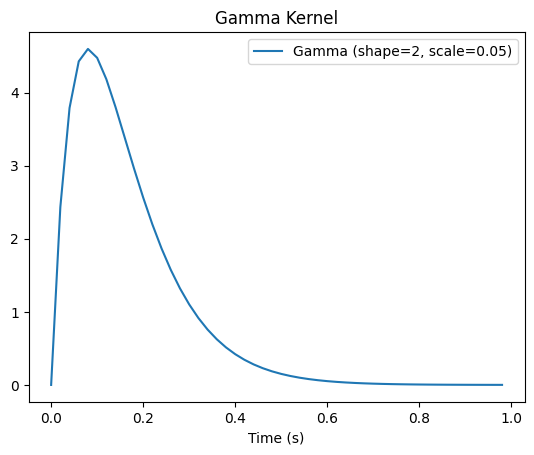

In [10]:
# Generate our kernel:
t = np.arange(0, 1, 1 / sfreq)  # time vector (in seconds)
kernel = gamma_dist(a=2, scale=0.08).pdf(t)
# kernel /= kernel.max()  # Normalize peak to 0.25

# Plot the kernel:
fig, ax = plt.subplots()
ax.plot(t, kernel, label="Gamma (shape=2, scale=0.05)")
ax.legend()
ax.set_title("Gamma Kernel")
ax.set_xlabel("Time (s)")
plt.show()

You can play around with the shape and scale parameters to obtain different temporal profiles. I chose these parameters as I thought they look reasonable. Note that here, despite the kernel starting at t = 0, when we convolve it with the data, it will start to rise only from the first sample at which we have an effect and ramp up from there. So don't try to specify a kernel that starts at the time point you'd want to see your effect, this is taken care of above by specifying the time window for your effect. 

## 4. Simulating the data

The simulation of the data is exactly the same as before, except for the additional kernel parameter:

In [ ]:
from multisim import Simulator

sims = Simulator(
    X,  # Design matrix
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    t_win,  # Time window of the effects
    effects,  # Which effects
    ch_cov=ch_cov,  # Spatial covariance of the data
    effect_size=effect_size,  # Size of the effect
    kern=kernel,  # Temporal kernel
)
epochs = sims.export_to_mne(X=X[:, :2], cond_names=cond_names, mapping=mapping)

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching eve

## 5. Vizualizing the data:
Just as was the case before, we don't really see much when looking at the activity of a particular channel as we have added effects at the multivariate level. Our kernel doesn't change anything at that level. 

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


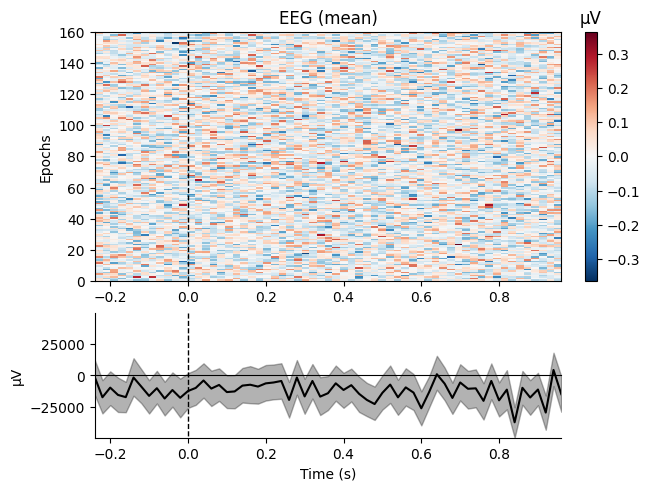

[<Figure size 640x480 with 3 Axes>]

In [12]:
epochs[0].plot_image(picks="eeg", combine="mean", scalings=dict(eeg=1))

## 6. Decoding analysis

### 6.1. Within subject analysis:
We can try to decode each of the labels of interest (face vs. objects and attended vs. unattended) for a given subject and we will see that these effects are present at the expected time points, but this time following the dynamics defined by our kernel:

Text(0.5, 1.0, 'Sensor space decoding')

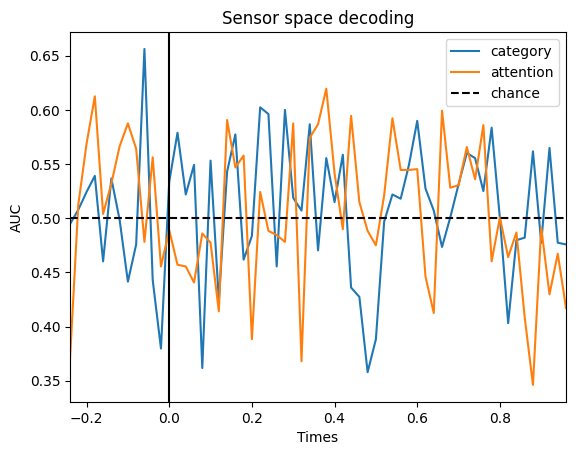

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract the data:
data = epochs[0].get_data()

# Decode faces vs. objects:
cate_lbl = np.array([mapping["category"][val] for val in X[:, 0]])
scores_category = np.mean(
    cross_val_multiscore(
        time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
    ),
    axis=0,
)

# Decode attended vs. unattended:
att_lbl = np.array([mapping["attention"][val] for val in X[:, 1]])
scores_attention = np.mean(
    cross_val_multiscore(
        time_decod, data, att_lbl, cv=5, n_jobs=None, verbose="WARNING"
    ),
    axis=0,
)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs[0].times, scores_category, label="category")
ax.plot(epochs[0].times, scores_attention, label="attention")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

### 6.2. Group level analysis
We simulated the data of 20 subjects, so we can investigate the evidence for decoding of the experimental manipulations at the group level. First, we need to perform the decoding on every single subject:

In [14]:
from mne.stats import permutation_cluster_1samp_test, bootstrap_confidence_interval

scores_category = []
scores_attention = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
            ),
            axis=0,
        )
    )
    # Classification of attention:
    scores_attention.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, att_lbl, cv=5, n_jobs=None, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)
scores_attention = np.array(scores_attention)

We can then apply a cluster based permutation test across subjects to find out when we have an effect:

In [15]:
# Cluster based permutation test for the category:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_category - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_cate = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_cate[clusters[c]] = True

# Cluster based permutation test for the attention:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_attention - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_att = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_att[clusters[c]] = True

Using a threshold of 1.729133
stat_fun(H1): min=-2.110506706845517 max=4.055641521694572
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 1.729133
stat_fun(H1): min=-1.6883996789639815 max=4.245757513011389
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Based on the input to the simulation, we would expect to see a significantly above chance decoding of face vs. object from 0.1 to 0.2 s, and then of attention from 0.3 to 0.4s. Let's check whether that is the case:

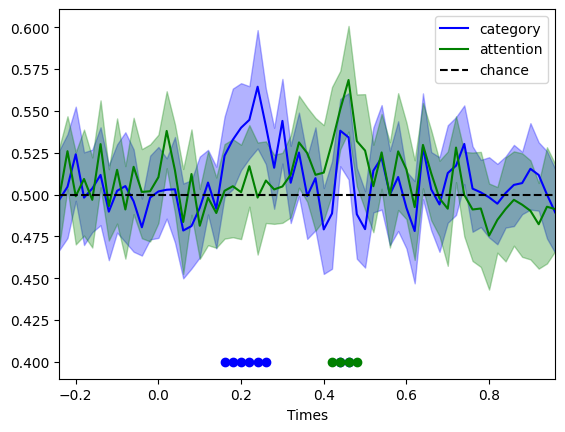

In [16]:
# Compute the confidence intervals:
ci_low_cate, ci_up_cate = bootstrap_confidence_interval(scores_category)
ci_low_att, ci_up_att = bootstrap_confidence_interval(scores_attention)

fig, ax = plt.subplots()
ax.plot(epochs[0].times, np.mean(scores_category, axis=0), label="category", color="b")
ax.fill_between(epochs[0].times, ci_low_cate, ci_up_cate, alpha=0.3, color="b")
ax.plot(
    epochs[0].times[sig_mask_cate],
    np.ones(np.sum(sig_mask_cate)) * 0.4,
    marker="o",
    linestyle="None",
    color="b",
)

ax.plot(
    epochs[0].times, np.mean(scores_attention, axis=0), label="attention", color="g"
)
ax.fill_between(epochs[0].times, ci_low_att, ci_up_att, alpha=0.3, color="g")
ax.plot(
    epochs[0].times[sig_mask_att],
    np.ones(np.sum(sig_mask_att)) * 0.4,
    marker="o",
    linestyle="None",
    color="g",
)
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.legend()
plt.show()

These results align with what we would expect. However, you probably noticed that this time, the effect don't seem to be restricted to the time points we have specified. That's to be expected. The gamma kernel are convolved with the time windows of our effects, so the effects gets protruded in time. If you want to avoid this, you should specify your effect as a single point in time (one sample) which when convolved with a temporally extended kernel will become protruded in time. You can then play around with the spread of your kernel to control the duration of the effect. So when using a kernel, it is a bit less straight forward to specify clear time points for your effects. 

One additional thing you may have noticed is that the amplitude of the effect seem to be larger than before. That also is to be expected. Our gamma kernel has a max value of 1, but since we are convoluting it with the effect of a set amplitude, we are essentially summing up the amplitude of neighboring time points. So here again, you'd need to adjust your gamma kernel max amplitude if you want to make sure you stay below a certain decoding accuracy threshold. Alternatively, you can modify the amplitude parameter of the simulator, or you can play with both options. You can either guesstimate by trying various factors for your kernel or find an analytical solution